# A gentle introduction to custom gradient propagation in machine learning for LTI systems in Laplace domain 

NOTE: for faster computation, the verification of the gradient via `torch.autograd.gradcheck` is disabled. Set it to `False` to enable it

In [1]:
FAST_COMPUTATION = True

Import the needed libraries

In [2]:
import numpy as np
import torch
import control as ct
import matplotlib.pyplot as plt
from torch.autograd import Function

Given the generic linear system

\begin{align*}
    \dot{x}(t) &= \text{A}x(t) + \text{B}u(t) \\
    y(t) &= \text{C}x(t) + \text{D}u(t)
\end{align*}

With system matrices $\text{A}$, $\text{B}$, $\text{C}$, and $\text{D}$:

\begin{align*}
    \text{A} &= \begin{bmatrix}
        a_{11} & a_{12} \\
        a_{21} & a_{22}
    \end{bmatrix} \\
    \text{B} &= \begin{bmatrix}
        b_1 \\
        b_2
    \end{bmatrix} \\
    \text{C} &= \begin{bmatrix}
        c_1 & c_2
    \end{bmatrix} \\
    \text{D} &= \begin{bmatrix}
        d_1
    \end{bmatrix}
\end{align*}

and its associated transfer function

\begin{align*}
\text{G}(s) &= \text{C}(s\text{I} - \text{A})^{-1}\text{B}+\text{D}\\
\text{G}(s) &= \frac{d_{1} s^{2}+\left(-a_{{11}} d_{1}-a_{{22}} d_{1}+b_{1} c_{1}+b_{2} c_{2}\right) s +\left(a_{{22}} d_{1}-b_{2} c_{2}\right) a_{{11}}-a_{{22}} b_{1} c_{1}+a_{{21}} b_{1} c_{2}+a_{{12}} b_{2} c_{1}-a_{{12}} a_{{21}} d_{1}}{s^{2}+\left(-a_{{22}}-a_{{11}}\right) s +a_{{11}} a_{{22}}-a_{{12}} a_{{21}}}
\end{align*}

try to optimize the system parameters using `PyTorch` library.


The implementation of such method enables to enhance more complex ML applications via the exploitation of physical knowledge of the system (see Physics-Informed Neural Networks - PINNs).



In [3]:
# Define a generic system and its transfer function
def model(params, ):
    """Create state-space representation and return the system transfer function.
    - params: parameters for the state-space matrices. 
    NOTE: The system transfer function is computed via control library, that does not natively support backpropagation of the gradient.
    """

    A = torch.tensor([[params[0], params[1]],
                      [params[2], params[3]]], dtype=torch.double)
    
    B = torch.tensor([params[4], params[5]], dtype=torch.double)

    C = torch.tensor([params[6], params[7]], dtype=torch.double)

    D = torch.tensor([params[8]], dtype=torch.double)

    G = ct.ss2tf(A, B, C, D)

    return G

# Define the goal parameters to be identified
ref_params = torch.tensor([-1, 1, 3, -4, 1, -1, 0, 1, 0], dtype=torch.double)

The desired transfer functions is

In [4]:
model(ref_params)

TransferFunction(array([-1.,  2.]), array([1., 5., 1.]))

In order to get the system *impulse respons* and *forced response to input*, the functions `impulse_response` and `forced_response` are introduced 

In [5]:
# Define forced and impulse response functions to test the system
def forced_response(trn_fcn, u, time):
    """
    Return a torch tensor containing the impulse response of the system
    - trn_fcn: transfer function on which to compute the impulse resonse
    - time: time array during which the impulse response has to be computed
    """
    output = ct.forced_response(trn_fcn, time, u.detach().numpy()).outputs
    output = torch.tensor(output.copy(), requires_grad=True, dtype=torch.double)
    return output

def impulse_response(trn_fcn, time):
    """
    Return a torch tensor containing the impulse response of the system
    """
    output = ct.impulse_response(trn_fcn, time).outputs
    output = torch.tensor(output.copy(), requires_grad=True, dtype=torch.double)
    return output

To be less dependent on the `forced_response` function, a torch-compatible convolution operator can be designed.

The *forced response to input* can be see in time domain as the convolution of the input with the transfer function
\begin{equation*}
y = \left(f \circledast  g\right)(t)
\end{equation*}

where $g$, the time-domain transfer function, acts as convolution kernel.

In [6]:
def conv_torch(u:torch.Tensor, g:torch.Tensor, t):
    """
    Manual implementation of the convolution operator to support torch tensors
    - u: input
    - g: kernel
    """
    if not (isinstance(g, list) or isinstance(g, tuple)): g = [g]
    out = []
    for kernel in g:
        # Pre-allocate memory for performances
        yt = torch.zeros_like(t)
        for i in range(len(t)):
            # Time span on which evalute G and integrate. Note: tau \in [0, t]
            tau = np.arange(0, i)
            tmp = u[tau]*kernel[i - tau]
            yt[i] = torch.trapz(tmp, t[0:i])
        out.append(yt)
    
    return out

To update and optimize the unkown system parameters, a gradient-based optimizer is used. 

The gradient of the loss with respect to system parameters is computed via the chain rule. However, its propagation can automatically occur if the *torch computation graphs* are not lost during the mathematical steps.

Unfortunately, since in this use case the system is defined in Laplace domain and no torch-compatible library is used to switch back to time domain, the computation graph is lost and therefore a manual computation of the gradient is needed.

Generally speaking, by manually computing the gradient, gradient-based training can be applied to general *unknown functions* and *FMUs*.

In this case, the gradient is estimated via centered-finite differences method.

In [6]:
def get_magnitude_torch(tensor):
    """
    Compute the magnitude of a torch value
    - tensor: torch tensor
    """
    if torch.equal(tensor, torch.zeros_like(tensor)):
        return 0  # Magnitude of a zero tensor is 0

    magnitude = int(torch.floor(torch.log10(tensor.abs())).item())
    return magnitude
    

def grad(f, x, h=None):
    """
    Return the gradient, as list of partial derivatives
    computed via (centered) finite differences.
    - f: function, callable. Function f on which to compute the gradient
    - x: parameter with respect to compute the gradient
    - h: step size for finite differences gradient computation

    NOTE: according to the parameter magnitude, a tailored step size h is required.
    This gradient implementation takes into account that

    NOTE: for parameters with magnitude of 1e4, h=1e-2 is demonstrated to be significant
    """

    grads, hs = [], []
    if (h is None): # h is set to auto
        for x_i in x:
            # Get the magnitude of the parameter
            coeff = get_magnitude_torch(x_i) - 6
            hs.append(float(10**coeff))
    else:
        hs = [h for _ in x]


    for i in range(len(x)):
        # NOTE: the copy of x will be with requires_gradient=False
        x_p = x.clone()
        x_m = x.clone()

        x_p[i] += hs[i]
        x_m[i] -= hs[i]

        dfdi = (f(x_p) - f(x_m))/(2*hs[i])
        grads.append(dfdi)

    return grads

In order to exploit the custom gradient and extending  PyTorch capabilities,  `torch.autograd` has to be enhanced via the definition of a custom class that inherits from `torch.autograd.Function`.

In [7]:
# Extend autograd capabilities by creating a custom Function class
class TransferFunction(Function):
    """
    Extend torch.autograd capabilities by designing a custom class TransferFunction that inherits from torch.autograd.Function.
    This allows to manually define both forward and backward methods.
    The gradient is propagated in the backward method via JVP
    """

    @staticmethod
    def forward(ctx, function_input, u, time):

        # Direct computation: compute the forward operation i.e the output of the transfer function
        output = forced_response(model(function_input), u, time)

        # Save the current input and output for further computation of the gradient
        ctx.save_for_backward(function_input, u, time) 
             
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Try to bind the output gradient with the input gradient. i.e. chain rule

        f_input, u, time, = ctx.saved_tensors

        # Create g(x) where x are the params
        gx = lambda p: forced_response(model(p), u, time)
                
        # Compute the gradients wrt each parameter
        # grads = grad(gt, params, h=1e-1)
        grads = grad(gx, f_input, h=1e-3)

        # Apply the chain rule for each partial derivative to update each parameter p
        # out = [grad_output*i for i in conv_torch(u, grads, t=time)]
        out = [grad_output*i for i in grads]
        
        # Convert the output from a list of partial derivatives to a N-by-p matrix, with p number of parameters, N size of data over time
        out = torch.stack(out, dim=1)

        # sum all the gradients to match the needed output dimension, i.e. p
        out = torch.sum(out, dim=0)

        return out, None, None

myTransferFunction = TransferFunction.apply

Let's define the input to be applied to the system over time

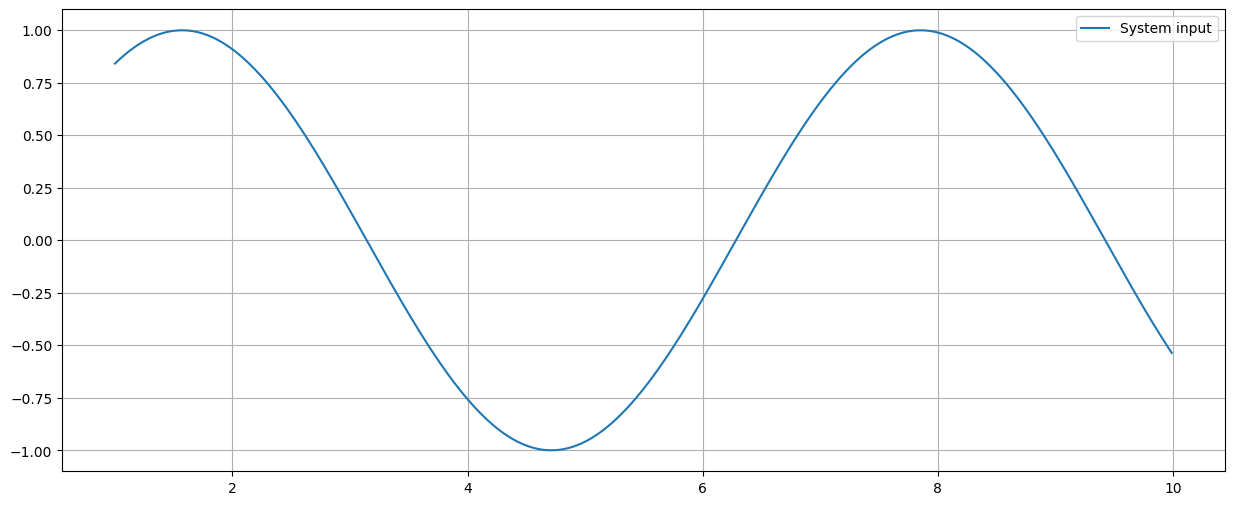

In [8]:
# Definition of time, input, parameters, ground truth
time = torch.tensor(np.linspace(1, 10, 1001, endpoint=False))
u    = torch.sin(time) #.requires_grad_(True)

plt.figure(figsize=[15,6])
plt.plot(time, u.detach(), label="System input")
plt.grid()
plt.legend()
plt.show()

Let's now verify if the custom gradient implementation is correct by means of `torch.autograd.gradcheck` function

In [9]:
# Definition of time, input, parameters, ground truth
time = torch.tensor(np.linspace(1, 10, 1001, endpoint=False))
u    = torch.sin(time).requires_grad_(True)

if (not FAST_COMPUTATION):
    test_passed = torch.autograd.gradcheck(myTransferFunction, (ref_params.requires_grad_(True), u.requires_grad_(False), time.requires_grad_(False)))
    print(f"Is the gradient correct? {test_passed}")

The true output of the system can be found by feeding the chosen input to the true system via the `forced_response` method.

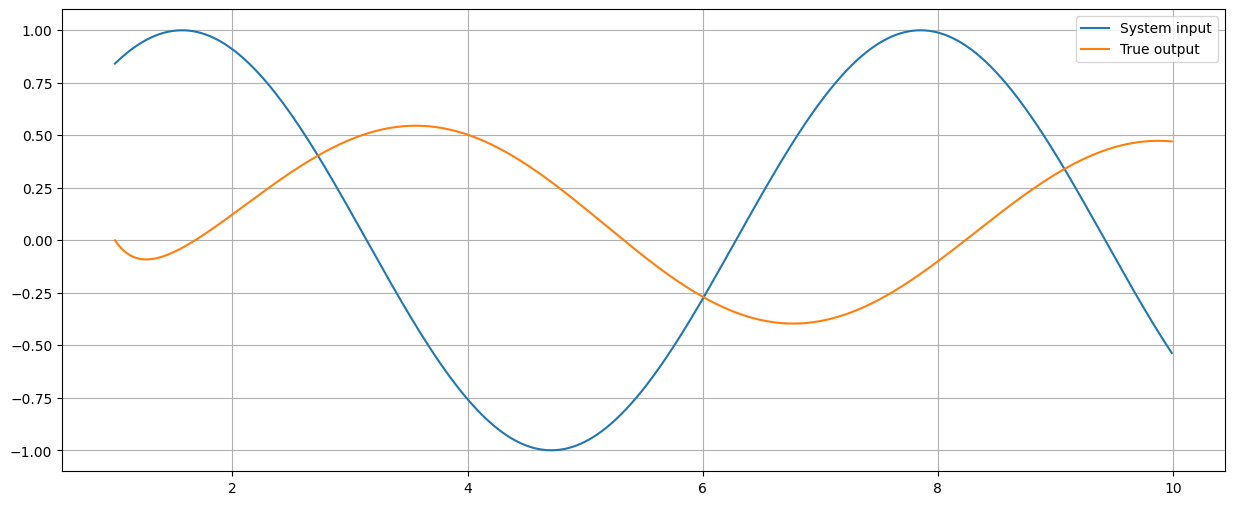

In [10]:
true_output = forced_response(model(ref_params), u, time)

plt.figure(figsize=[15,6])
plt.plot(time, u.detach().numpy(), label="System input", alpha=1)
plt.plot(time, true_output.detach(), label="True output", alpha=1)
plt.grid()
plt.legend()
plt.show()

Now, given an initial parameter vector with random values, try to optimize them to match the true (reference) output

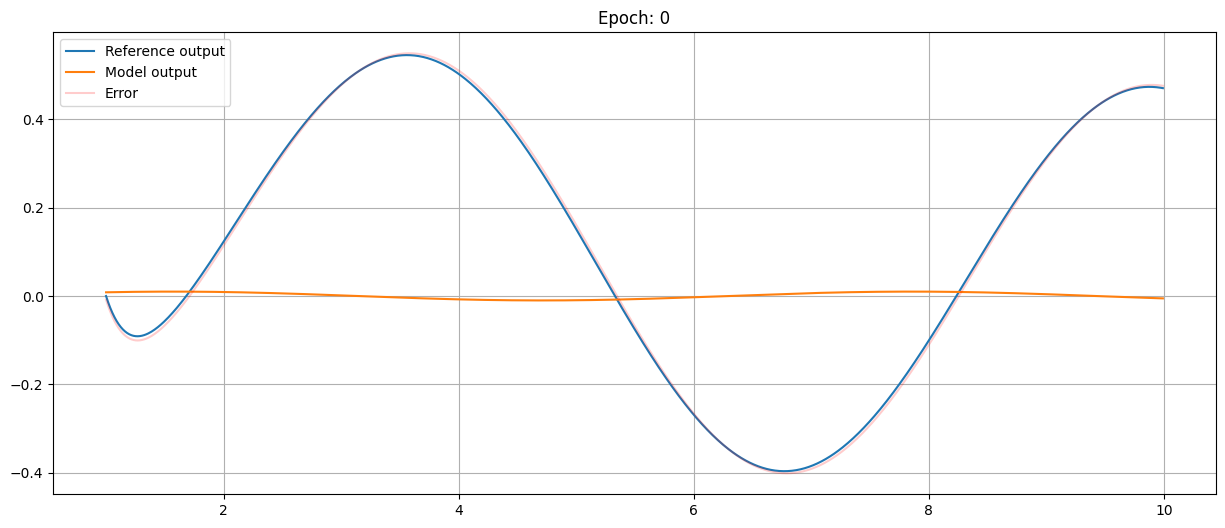

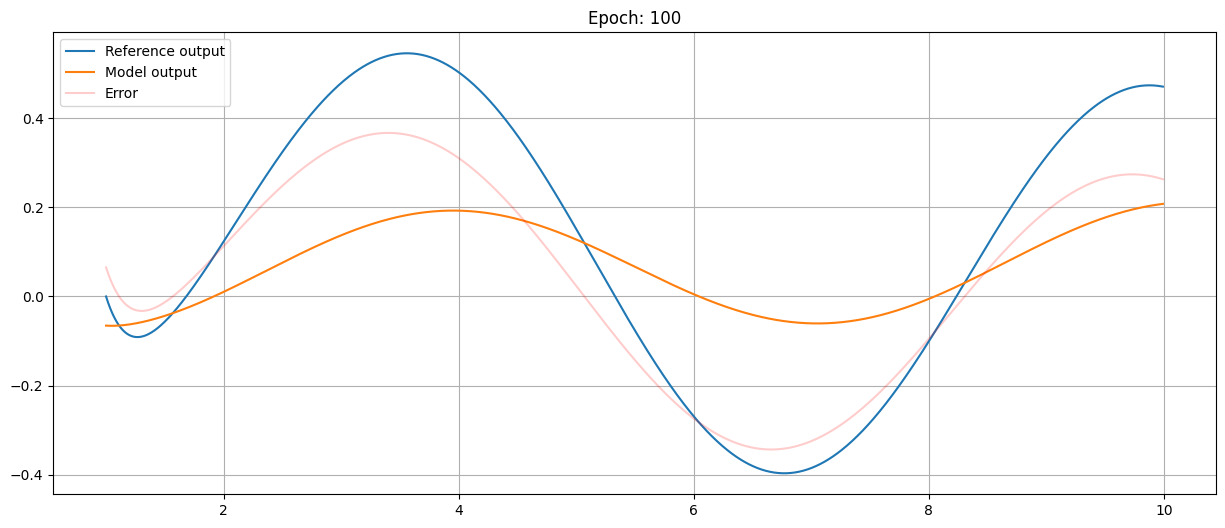

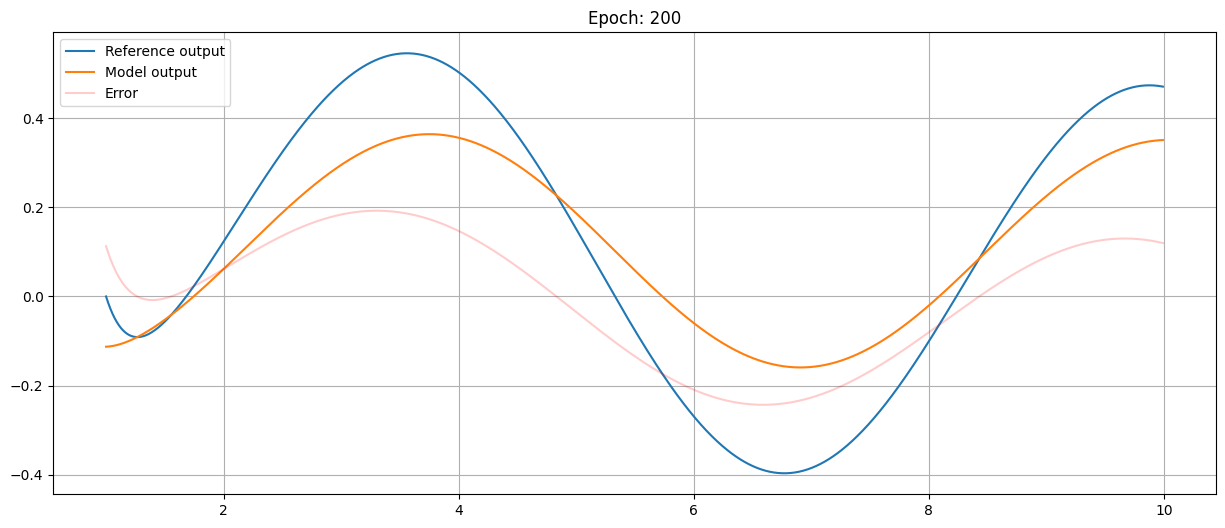

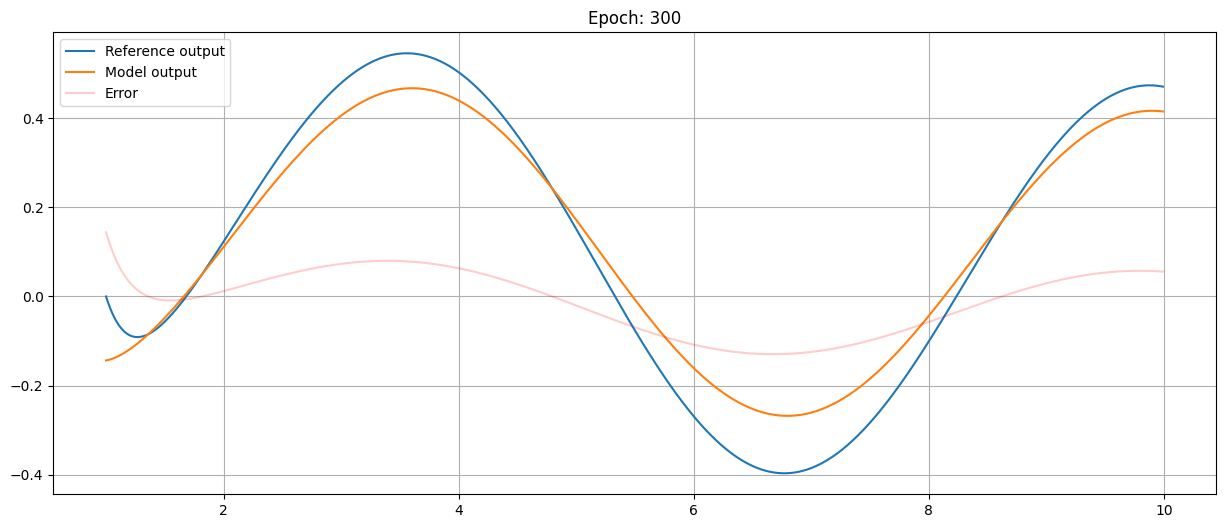

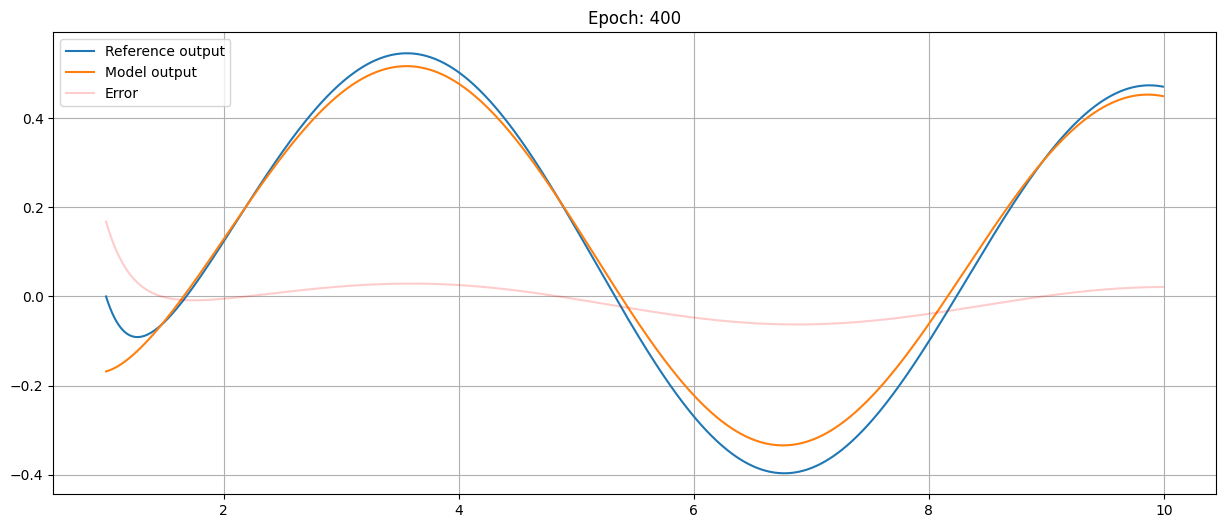

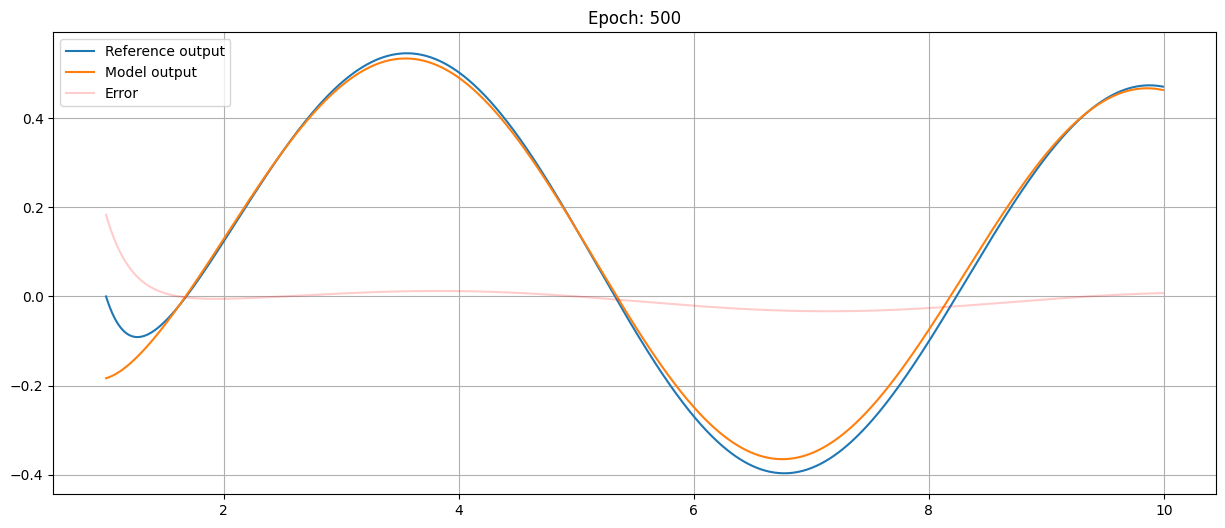

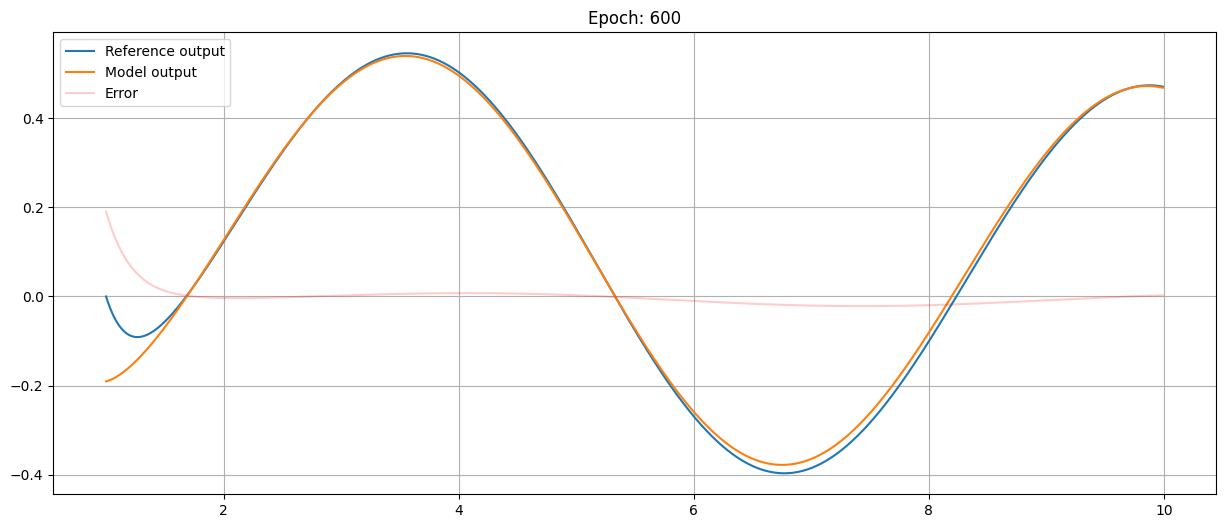

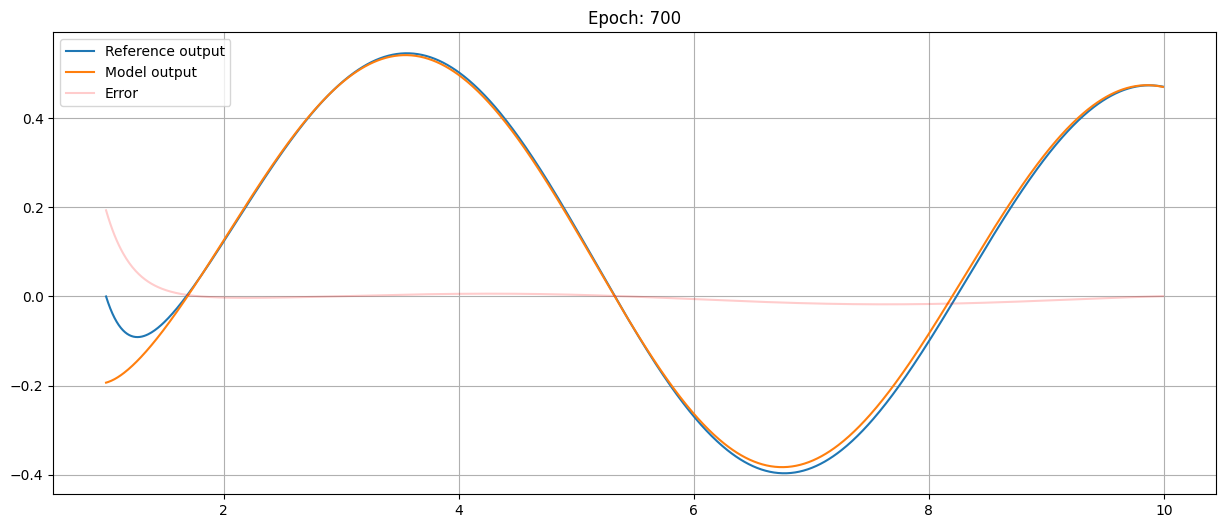

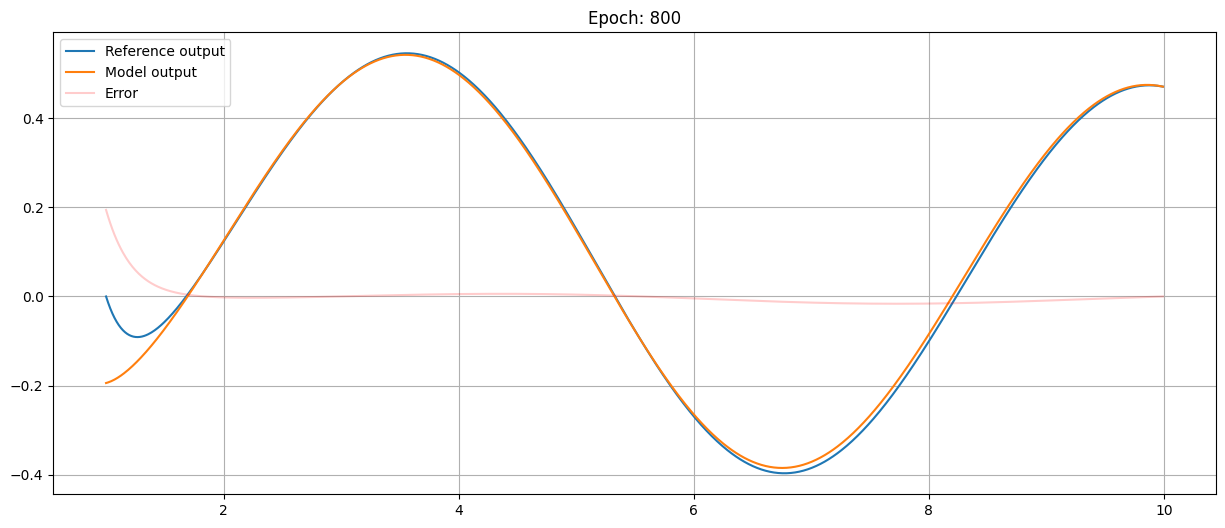

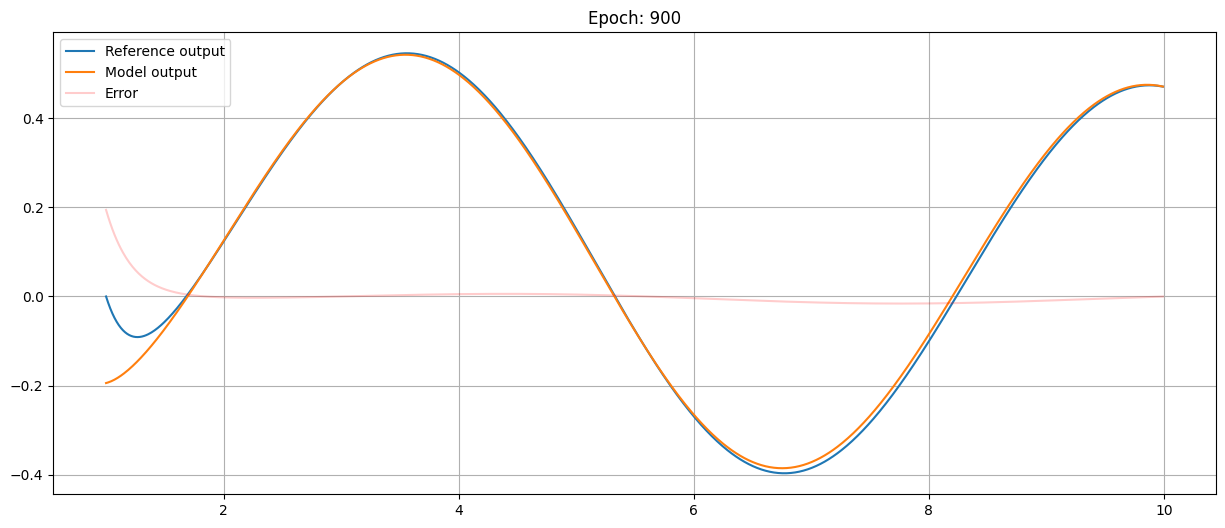

True parameters:      tensor([-1.,  1.,  3., -4.,  1., -1.,  0.,  1.,  0.], dtype=torch.float64)
Estimated parameters: tensor([-0.5111,  1.1761,  1.4867, -5.4288, -0.2886, -0.2979, -1.4246,  0.6188,
        -0.2305], dtype=torch.float64, requires_grad=True)


In [11]:
# Set manual seed for reproducibility
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_EPOCHS, LEARNING_RATE = 1000, 1e-3


# Initial guess
params = torch.tensor([-0.5, 1, 2, -5, 0, 0, -1, 1, 0.01], requires_grad=True, dtype=torch.double)


# model = Model().to(device)
# model.to(device)

optimizer = torch.optim.Adam([params], lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()


for epoch in range(NUM_EPOCHS):

    # Reset the gradient
    optimizer.zero_grad()         
    
    output = myTransferFunction(params, u, time)
    loss = criterion(true_output, output)
    
    # Optimize
    loss.backward()
    optimizer.step()

    if (epoch%100 == 0):
        plt.figure(figsize=[15,6])
        plt.plot(time, true_output.detach(), label="Reference output")
        plt.plot(time, output.detach(), label="Model output")
        plt.plot(time, (true_output.detach() - output.detach()), label="Error", alpha=0.2, color="red")
        plt.grid()
        plt.legend()
        plt.title(f"Epoch: {epoch}")
        plt.show()

print(f"True parameters:      {ref_params}")
print(f"Estimated parameters: {params}")
        